In [1]:
import os

In [2]:
train_path = 'data/train'
test_path = 'data/test'

categories = []
data_dict = {}
for branch in [test_path, train_path]:
    print('##', branch)
    for foldername in os.listdir(branch):

        if foldername != '.DS_Store':
            categories.append(foldername)
            count = len(os.listdir(os.path.join(branch, foldername)))
            if foldername not in data_dict:
                data_dict[foldername] = [count]
            else:
                data_dict[foldername].append(count)
            print(foldername + ': ', count)

categories = set(categories)

## data/test
happy:  1774
sad:  1247
fear:  1024
surprise:  831
neutral:  1233
angry:  958
disgust:  111
## data/train
happy:  7215
sad:  4830
fear:  4097
surprise:  3171
neutral:  4965
angry:  3995
disgust:  436


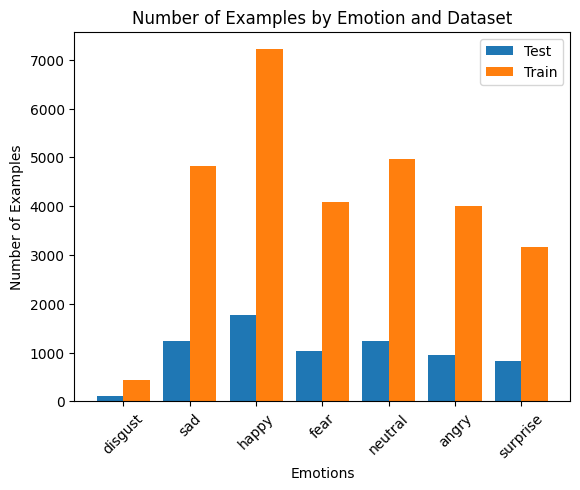

In [6]:
import matplotlib.pyplot as plt
test_counts = [data_dict[cat][0] for cat in categories]
train_counts = [data_dict[cat][1] for cat in categories]

# Set up the plot
fig, ax = plt.subplots()

# Plotting
bar_width = 0.4
index = range(len(categories))
bars1 = ax.bar(index, test_counts, bar_width, label='Test')
bars2 = ax.bar([p + bar_width for p in index], train_counts, bar_width, label='Train')

# Add details
ax.set_xlabel('Emotions')
ax.set_ylabel('Number of Examples')
ax.set_title('Number of Examples by Emotion and Dataset')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(categories)
ax.legend()

# Display the plot
plt.xticks(rotation=45)  # Rotate category names for better visibility
plt.show()

## Image Data Generator

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions and batch size
img_width, img_height = 48, 48
batch_size = 32

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,     # Normalize pixel values to [0,1]
    rotation_range=20,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,    # Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.2,     # Range for random zoom
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'   # Set strategy for filling in newly created pixels
)

# Test data shouldn't be augmented, but it should be normalized
test_datagen = ImageDataGenerator(rescale=1./255)

# Point to the directory where your training and test sets are
train_path = 'data/train'
test_path = 'data/test'

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    color_mode='grayscale',    # Images are in grayscale
    shuffle=True               # Shuffle the data for better training
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False               # No need to shuffle test data
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [9]:
%load_ext tensorboard

## Models

### CNN

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2

# Building the CNN
model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(img_width, img_height, 1), kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,456,967 (9.37 MB)

 Trainable params: 2,456,519 (9.37 MB)

 Non-trainable params: 448 (1.75 KB)

In [70]:
from tensorflow.keras.callbacks import TensorBoard
import datetime
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

log_dir = "logs/fourth_model_l2" #+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#%tensorboard --logdir "logs"

In [ ]:

# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.n // test_generator.batch_size,
    callbacks=[tensorboard_callback]  # Add TensorBoard to callbacks
)


In [8]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

### Resnet

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D, GlobalAveragePooling2D, Dense

def res_block(x, filters, kernel_size=3, downsample=False):
    y = Conv2D(filters, kernel_size, padding='same')(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)

    y = Conv2D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)

    if downsample:
        x = Conv2D(filters, 1, strides=2, padding='same')(x)
        y = MaxPooling2D((2, 2), strides=2, padding='same')(y)
    elif x.shape[-1] != filters:
        x = Conv2D(filters, 1, padding='same')(x)  # Match the number of filters

    out = Add()([x, y])
    out = ReLU()(out)
    return out


In [5]:
def build_resnet():
    inputs = Input(shape=(48, 48, 1))
    x = Conv2D(32, (3, 3), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = res_block(x, 32)
    x = res_block(x, 64, downsample=True)
    x = res_block(x, 128, downsample=True)
    x = res_block(x, 256, downsample=True)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(7, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [6]:
from tensorflow.keras.callbacks import TensorBoard
import datetime
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

log_dir = "logs/resnet_base" #+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#%tensorboard --logdir "logs"

In [7]:
model = build_resnet()  # grayscale implies 1 channel
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 24, 24,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 24, 24,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 24, 24,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 12, 12,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 12, 12,    │      9,248 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 12, 12,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │      9,248 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 12, 12,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 12, 12,    │          0 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │     18,496 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 12, 12,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 12, 12,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_4[0][0]  

 Total params: 1,230,151 (4.69 MB)

 Trainable params: 1,228,167 (4.69 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[tensorboard_callback] 
)

Epoch 1/50


/Users/alitavana/Desktop/Ata/PythonProjects/EmotionRecognition/venv-metal/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


897/897 ━━━━━━━━━━━━━━━━━━━━ 140s 149ms/step - accuracy: 0.2637 - loss: 1.8277 - val_accuracy: 0.2723 - val_loss: 1.7380
Epoch 2/50
  1/897 ━━━━━━━━━━━━━━━━━━━━ 1:55 129ms/step - accuracy: 0.2500 - loss: 1.7949

/Users/alitavana/miniforge3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step - accuracy: 0.2500 - loss: 1.7949 - val_accuracy: 0.0000e+00 - val_loss: 2.1537
Epoch 3/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 135s 151ms/step - accuracy: 0.3969 - loss: 1.5332 - val_accuracy: 0.4404 - val_loss: 1.4555
Epoch 4/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - accuracy: 0.3438 - loss: 1.5625 - val_accuracy: 1.0000 - val_loss: 0.3151
Epoch 5/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 134s 149ms/step - accuracy: 0.4508 - loss: 1.4243 - val_accuracy: 0.4862 - val_loss: 1.3288
Epoch 6/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - accuracy: 0.4688 - loss: 1.1029 - val_accuracy: 0.9000 - val_loss: 0.4945
Epoch 7/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 132s 147ms/step - accuracy: 0.4845 - loss: 1.3440 - val_accuracy: 0.4747 - val_loss: 1.3562
Epoch 8/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - accuracy: 0.6250 - loss: 1.1252 - val_accuracy: 0.4000 - val_loss: 1.2834
Epoch 9/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 137s 152ms/step - accuracy: 0.5037 - loss: 1.3041 -

## Testing model

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def load_and_predict(img_path, model):
    # Load and resize the image
    img = image.load_img(img_path, target_size=(img_width, img_height), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch shape
    img_array /= 255.0  # Normalize to [0,1]

    # Predict
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    return predictions, predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


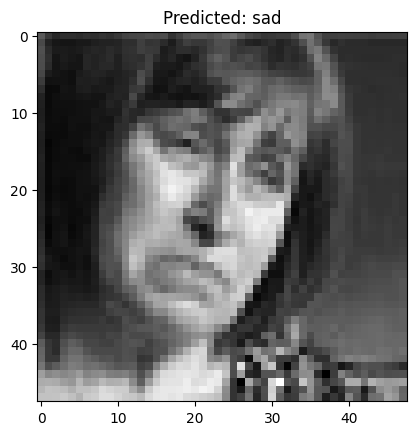

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


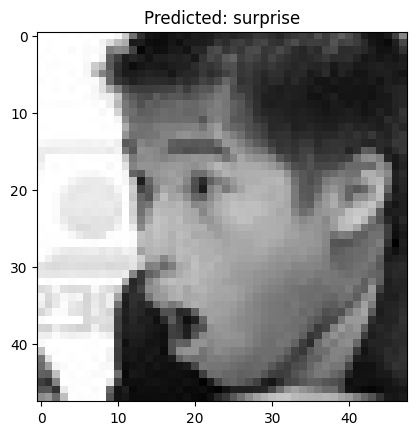

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


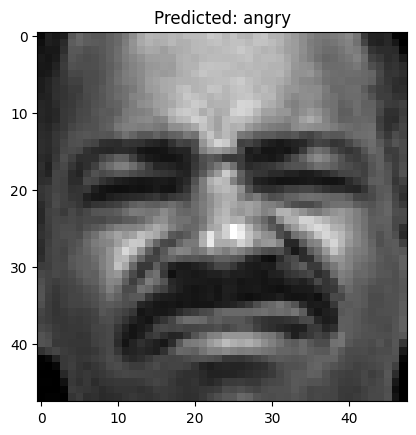

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


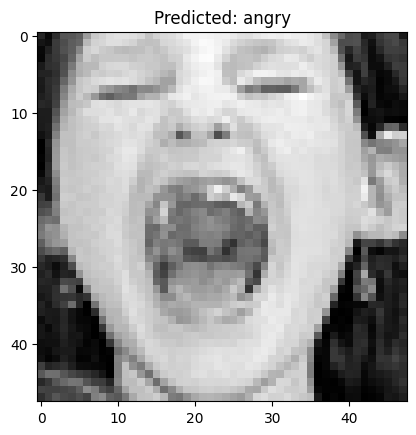

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


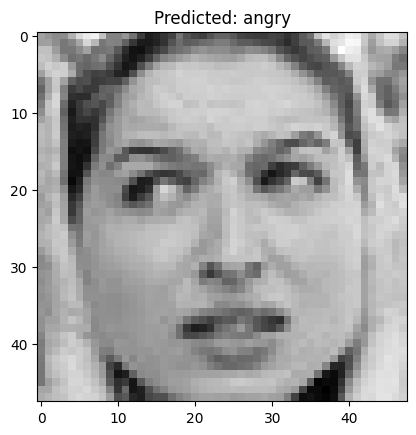

In [13]:
import os
import random

def display_random_predictions(model, test_dir, index_to_class, num_images=5):
    for _ in range(num_images):
        class_folder = random.choice(os.listdir(test_dir))
        class_path = os.path.join(test_dir, class_folder)
        img_path = os.path.join(class_path, random.choice(os.listdir(class_path)))
        predictions, predicted_class = load_and_predict(img_path, model)

        # Display the image and prediction
        img = image.load_img(img_path, color_mode='grayscale')
        plt.imshow(img, cmap='gray')
        plt.title(f'Predicted: {index_to_class[predicted_class[0]]}')
        plt.show()

# Example usage
test_dir = 'data/test'
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}
display_random_predictions(model, test_dir, index_to_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


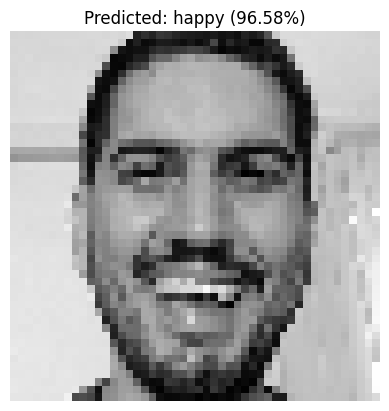

In [20]:
def predict_emotion(img_path, model, index_to_class):
    # Load the image, resize it, and convert to grayscale
    img = image.load_img(img_path, target_size=(img_width, img_height), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch shape
    img_array /= 255.0  # Normalize to [0,1]

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_probability = np.max(predictions, axis=1)

    # Display the image and prediction
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted: {index_to_class[predicted_class[0]]} ({predicted_probability[0]*100:.2f}%)')
    plt.axis('off')
    plt.show()

# Example usage
img_path = 'imgs/happy.jpg'
#model_path = 'path_to_your_saved_model.h5'
#model = load_model(model_path)
class_indices = train_generator.class_indices  # Ensure this is defined in your environment
index_to_class = {v: k for k, v in class_indices.items()}
predict_emotion(img_path, model, index_to_class)